# Seq2Seq Q&A chatbot 구현

In [23]:
# !pip install tensorflow
# !pip install sentencepiece

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]
df


,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


데이터 전처리

## 토커나이저 학습 (sentencepiece 활용)

- 접두사, 접미사 처리 (문장의 처음과 끝에 오는 'sos','bos'처리)

In [45]:
q_input = []
a_input = []
a_target = []
#우선 Q 데이터랑 A 데이터를 각각 q_input, a_input, a_target으로 나눠서 저장
for string in df['Q']:
    q_input.append(string)
for string in df['A']:
    a_input.append("<s> " + string)
    a_target.append(string + " </s>")
print(q_input[:3])
print(a_input[:3])
print(a_target[:3])
#question_input 과 answer_input / answer_target으로 나눔, 여기서 answer_target을 따로 나누는 이유는 teacher forcing을 위해서임

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']
['<s> 하루가 또 가네요.', '<s> 위로해 드립니다.', '<s> 여행은 언제나 좋죠.']
['하루가 또 가네요. </s>', '위로해 드립니다. </s>', '여행은 언제나 좋죠. </s>']


In [27]:
VOCAB_SIZE = 9000

In [28]:
# 우선 저기 있는 데이터를 하나의 text 파일로 합침
all_text = q_input + a_input
with open("all_text.txt", "w", encoding="utf-8") as f:
    for text in all_text:
        f.write(text + "\n")
# df에 있는 데이터를 with open으로 w해가지고 text에 줄 단위로 넣어놓음

In [29]:
# 그러면 만들어진 텍스트에 대해서 모델을 토큰화시키는거임 sentencepiece로
import sentencepiece as spm
spm.SentencePieceTrainer.train(
    input = r"all_text.txt",
    model_prefix = "tokenizer",
    vocab_size = VOCAB_SIZE,
    model_type = "unigram",
)
# 그 다음에 SentencePiece를 이용해서 문장을 토큰화시킨거임, 그러면 vocab_size만큼의 토큰이 만들어지겠지

In [30]:
sp = spm.SentencePieceProcessor()
sp.load("tokenizer.model")

print("==== Vocabulary ====")
for i in range(sp.get_piece_size()):
    piece = sp.id_to_piece(i)
    print(i, piece)
#spm 안의 SentencePieceProcessor을 이용해서 인코딩까지 가능함

==== Vocabulary ====
0 <unk>
1 <s>
2 </s>
3 ▁
4 .
5 요
6 ?
7 을
8 가
9 도
10 이
11 게
12 는
13 ▁거예요
14 은
15 고
16 를
17 지
18 보세요
19 ▁수
20 세요
21 의
22 네요
23 ▁너무
24 ▁좋아하는
25 ▁더
26 ▁잘
27 ▁거
28 ▁사람
29 ▁안
30 서
31 ▁것
32 한
33 에
34 면
35 ▁많이
36 ▁사랑
37 ▁좋은
38 ▁나
39 해보세요
40 죠
41 봐요
42 ▁그
43 히
44 만
45 ▁좀
46 ▁같아요
47 ▁사람이
48 랑
49 나
50 ▁있을
51 ▁있어요
52 ▁싶어
53 으로
54 ▁이별
55 ▁생각
56 ▁없어
57 로
58 ▁마음
59 ▁썸
60 !
61 ▁때
62 ▁같아
63 하고
64 ▁내
65 길
66 할
67 ▁마세요
68 ▁말
69 다
70 ▁건
71 ▁이제
72 ▁오늘
73 ▁다
74 ▁게
75 ▁마음이
76 ▁내가
77 네
78 ▁있는
79 ▁왜
80 에서
81 ▁다른
82 ▁있
83 ▁어떻게
84 이에요
85 ▁남자친구
86 하는
87 일
88 ▁연락
89 ▁싶다
90 ▁시간이
91 ▁다시
92 ▁여자친구
93 ▁뭐
94 ▁정말
95 ▁있어
96 ▁또
97 ▁연애
98 ▁저
99 ▁좋을
100 ▁않아
101 ▁해보세요
102 어
103 ▁수도
104 겠어요
105 니다
106 ▁좋아
107 ▁걸
108 ▁친구
109 야
110 ▁조금
111 ▁못
112 ▁같이
113 ▁여자
114 하세요
115 ▁자신
116 ▁지금
117 ▁일
118 에요
119 ▁될
120 ▁혼자
121 는데
122 으면
123 해
124 어요
125 ▁자꾸
126 ▁그런
127 ▁바
128 ▁것도
129 가봐요
130 ▁당신
131 기
132 ▁해
133 하지
134 거예요
135 ▁하는
136 년
137 ▁시간
138 인데
139 ▁힘들
140 거
141 ▁한
142 든
143 ▁일이
144 과
145 ▁아니
146 ▁바랄게요
147 ▁진짜
148

In [31]:
# 토큰화 후 수동으로 특수 토큰 추가
question_seq = [sp.encode_as_ids(text) for text in q_input]
answer_input_seq = [[sp.bos_id()] + sp.encode_as_ids(text) for text in a_input]
answer_target_seq = [sp.encode_as_ids(text) + [sp.eos_id()] for text in a_target]

print("수정된 결과:")
for i in range(3):
    print(f"답변 입력: {answer_input_seq[i]}")
    print(f"답변 타겟: {answer_target_seq[i]}")
print(len(question_seq), len(answer_input_seq), len(answer_target_seq))

#토큰화 후에 인코딩까지 함

수정된 결과:
답변 입력: [1, 3, 0, 4182, 0, 252, 8, 96, 3, 8, 22, 4]
답변 타겟: [252, 8, 96, 3, 8, 22, 4, 3, 0, 4182, 0, 2]
답변 입력: [1, 3, 0, 4182, 0, 1411, 3, 3665, 4]
답변 타겟: [1411, 3, 3665, 4, 3, 0, 4182, 0, 2]
답변 입력: [1, 3, 0, 4182, 0, 293, 14, 356, 49, 183, 4]
답변 타겟: [293, 14, 356, 49, 183, 4, 3, 0, 4182, 0, 2]
11823 11823 11823


In [32]:
q_max_len = max(len(seq) for seq in question_seq)
a_max_len = max(len(seq) for seq in answer_input_seq)

padding


In [33]:
q_inputs_padded = pad_sequences(question_seq, maxlen = q_max_len, padding='post')
a_inputs_padded = pad_sequences(answer_input_seq, maxlen = a_max_len, padding='post')
a_targets_padded = pad_sequences(answer_target_seq, maxlen = a_max_len, padding='post')

print(q_inputs_padded.shape)
print(a_inputs_padded.shape)
print(a_targets_padded.shape)
# 인코딩을 완료한 후에 각 sequences에 대해서 padding을 진행함(나중에 batch화 해가지고 행렬 연산 해버리게)

(11823, 24)
(11823, 40)
(11823, 40)


In [34]:
EMBEDDING_DIM = 100
print(q_max_len, a_max_len)

24 40


##### 인코더 생성


In [35]:
vocab_size = sp.get_piece_size()  # SentencePiece 어휘 크기
print(f"실제 어휘 크기: {vocab_size}")
a_words_num = vocab_size  # 또는 vocab_size
q_words_num = vocab_size
# 그러면 vocab_size만큼 encoding이 완료됐고, encoding 된거 embedding 해야함

실제 어휘 크기: 9000


In [36]:
from tensorflow.keras import layers, models

LATENT_DIM = 512 # Changed LATENT_DIM to 128
#sequence 하나가 max 20임 encoder_inputs는 그래서 20
encoder_inputs = layers.Input(shape=(q_max_len,))
#이제 임베딩시키면 됨, 인코딩된 시퀀스들을 임베딩시킴
q_embedding_layer = layers.Embedding(
    input_dim = q_words_num,
    output_dim = EMBEDDING_DIM,
    mask_zero = False
)
#문장에 대해 embedding시킨 텐서x를 반환
x = q_embedding_layer(encoder_inputs)
#반환시킨 텐서를 input으로 한 LSTM 모델 생성해서 h, c 반환
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True, dropout= 0.2)(x)
encoder_states = [h, c]
#결국 input이 요게 들어오면 output은 h, c가 나와야함
encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)
#

##### 디코더 생성(teacher-forcing 모델) 생성


In [37]:
# 디코더 (teacher forcing)
#디코더는 input으로 answer 이 들어옴
decoder_inputs = layers.Input(shape=(a_max_len,))
#그래서 answer 인코딩 된거를 -> 임베딩 시키고
a_embedding_layer = layers.Embedding(
    input_dim = a_words_num,
    output_dim = EMBEDDING_DIM,
    mask_zero = False # Changed mask_zero to False
)
#x는 answer을 임베딩 시킨거임
x = a_embedding_layer(decoder_inputs)
# 그 다음에
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, dh, dc = decoder_lstm(x, initial_state=encoder_states)
decoder_dense = layers.Dense(a_words_num, activation='softmax')  # +1 제거
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)

##### 모델 컴파일 시키고 학습


In [38]:
from tensorflow.keras.optimizers import Adam

decoder_teacher_forcing_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),  # 학습률 명시적 설정
    metrics=['accuracy']
)

# 데이터 형태 확인
print("Input shapes:")
print("q_inputs_padded:", q_inputs_padded.shape)
print("a_inputs_padded:", a_inputs_padded.shape)
print("a_targets_padded:", a_targets_padded.shape)
print("\nVocab size:", vocab_size)
print("Max target value:", np.max(a_targets_padded))

history = decoder_teacher_forcing_model.fit(
    [q_inputs_padded, a_inputs_padded],
    a_targets_padded,

    batch_size=32,
    epochs=80,  # 우선 10 에폭으로 테스트
    validation_split=0.2,
    verbose=1
)

Input shapes:
q_inputs_padded: (11823, 24)
a_inputs_padded: (11823, 40)
a_targets_padded: (11823, 40)

Vocab size: 9000
Max target value: 8999
Epoch 1/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.7530 - loss: 2.1805 - val_accuracy: 0.7703 - val_loss: 1.5048
Epoch 2/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.8047 - loss: 1.1893 - val_accuracy: 0.7732 - val_loss: 1.4963
Epoch 3/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.8130 - loss: 1.1366 - val_accuracy: 0.7742 - val_loss: 1.4987
Epoch 4/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.8167 - loss: 1.1095 - val_accuracy: 0.7749 - val_loss: 1.5074
Epoch 5/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.8190 - loss: 1.0971 - val_accuracy: 0.7766 - val_loss: 1.5257
Epoch 6/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.8284 - loss: 1.0486 - val_accuracy: 0.7742 - val_loss: 1.5403
Epoch 7/80
296/296 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.8324 - lo

##### 디코더(추론 모델 생성) & 추론 함수 생성


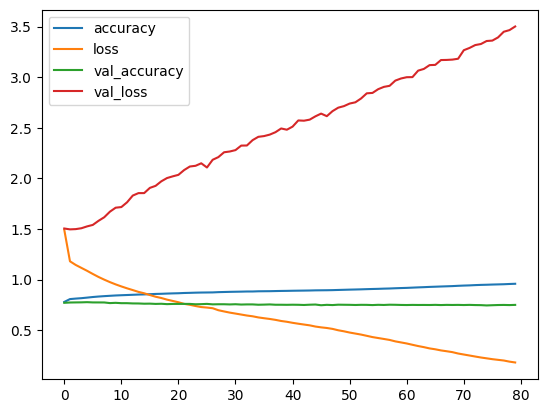

In [39]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.show()

In [40]:
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')


In [41]:
from tensorflow.keras.models import load_model
decoder_teacher_forcing_model = load_model('decoder_teacher_forcing_model.keras')

##### 테스트

### 간단한 Chatbot 구현

1. 사용자의 입력을 받아서(처리)

2. 추론 함쉥 전달해서

3. 응답을 출력

4. 1~3 을 종료 전까지 반복

In [ ]:
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape= (LATENT_DIM,))
decoder_states_input = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))
x = a_embedding_layer(decoder_single_input)
x,h,c = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)(x,initial_state=decoder_states_input)
decoder_statees = [h,c]
decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs = [decoder_single_input] + decoder_states_input,
    outputs = [decoder_outputs_] + decoder_statees
)
decoder_inference_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 100)    │    900,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_3[1][0… │
│                     │ (None, 512),      │            │ input_layer_7[0]… │
│                     │ (None, 512)]      │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 9000)   │  4,617,000 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,772,424 (25.83 MB)

 Trainable params: 6,772,424 (25.83 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
def translate(input_seq):
    # 인코더로 질문 이해
    encoder_states_value = encoder_model.predict(input_seq)
    decoder_states_value = encoder_states_value

    # SentencePiece 토큰 사용
    sos_index = sp.bos_id()  # <s> 토큰
    eos_index = sp.eos_id()  # </s> 토큰

    target_seq = np.zeros((1,1))
    target_seq[0,0] = sos_index

    output_sentence = []

    for _ in range(a_max_len):  # kor_max_len 대신 a_max_len 사용
        output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value)

        pred_proba = output_tokens[0,0, :]
        pred_index = int(np.argmax(pred_proba))

        if pred_index == eos_index:
            break

        if pred_index > 0:
            # SentencePiece로 디코딩
            word = sp.id_to_piece(pred_index)
            output_sentence.append(word)

        target_seq[0,0] = pred_index
        decoder_states_value = [h,c]

    # SentencePiece 토큰들을 문장으로 결합
    return sp.decode(output_sentence)  # 또는 "".join(output_sentence)

In [47]:
# 새로운 질문들로 테스트
test_questions = [
  '12시 땡!',
  '집에 가고 싶다',
  '너무 힘들어',
  '코딩 재밌다'
]

print("=== 새로운 질문 테스트 ===")
for i, question in enumerate(test_questions):
    # 질문 전처리
    question_tokens = sp.encode_as_ids(question)
    question_padded = pad_sequences([question_tokens], maxlen=q_max_len, padding='post')

    # 답변 생성
    answer = translate(question_padded)

    print(f"\n--- 테스트 {i+1} ---")
    print(f"질문: {question}")
    print(f"답변: {answer}")
    print("-" * 30)

=== 새로운 질문 테스트 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39m